In [1]:
# import plot making essentials
import numpy as np
import matplotlib.pyplot as plt
from plotly import graph_objects as go

from pathlib import Path # for simplify creation of model paths

# importing PyTorch essentials
import torch
from torch import nn
from torch.nn import functional as F

# check version of PyTorch
print(f'version of PyTorch: {torch.__version__}')

version of PyTorch: 1.14.0.dev20221207


In [2]:
# determining if GPU resource is available for training
# training happened on Macbook Air with M2 chip
device='mps' if torch.cuda.is_available() else 'cpu'

# helper function for plot making
def make_plots(
    X, y_true, y_pred=None
):
  fig=go.Figure()
  fig.add_trace(
      go.Scatter(
          x=X.to('cpu').numpy().reshape(-1), 
          # moving Tensors from GPU to CPU first then turn to numpy array for plot making
          y=y_true.to('cpu').numpy().reshape(-1),
          mode='markers',
          name='actual'
      )
  ) # making scattered plots of the actual data
  if y_pred is not None:
    fig.add_trace(
        go.Scatter(
            x=X.to('cpu').numpy().reshape(-1),
            y=y_pred.to('cpu').numpy().reshape(-1),
            mode='markers',
            name='predicted'
        )
    ) # when provided with predicted values, making scattered plots of predicted values
  fig.update_layout(
      title='Prediction vs. True Values'
  )
  fig.show()

# helper function for making train vs. val loss comparisons
def loss_plotting(
    train_loss,
    val_loss,
):
  plt.plot(train_loss)
  plt.plot(val_loss)
  plt.legend(['train loss','val loss'])
  plt.title('train vs. validation losses')
  plt.show()

In [3]:
model_path=Path('models') # creation of the models dir path
model_path.mkdir(parents=True, exist_ok=True) # making the dir

model_name='chapter2_pytorch_workflow_exercise_model.pth' # name the model as
model_save_path=model_path/model_name

In [4]:
# creating fabricated linear regression data for simulation
weight=0.3
bias=0.9

X=torch.arange(0,1,0.005,dtype=torch.float32,device=device).unsqueeze(-1)
y=weight*X+bias+torch.randn_like(X)*0.05 # adding random noise to the fabricated data

randomized_idx=np.random.choice(np.arange(len(X)),len(X),replace=False) # shuffling train and test data
X=X[randomized_idx] # randomize data for train-test split
y=y[randomized_idx]

split=int(0.8*len(X)) # 80% for training, 20% for testing
X_train, X_test, y_train, y_test = X[:split],X[split:],y[:split],y[split:]

In [5]:
# creation of a simple linear regression model
class LinearModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear_layer1=nn.Linear(
        in_features=1,
        out_features=1,
        device=device
    ) # a linear regression model with just 1 layer: a weight parameter and a bias parameter

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    o1=self.linear_layer1(x)
    return o1

In [6]:
# model initializations, loss function and optimizer
model=LinearModel()
loss_fn=torch.nn.L1Loss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

epoch 500 | train loss: 0.03956037014722824 | eval loss: 0.041390661150217056


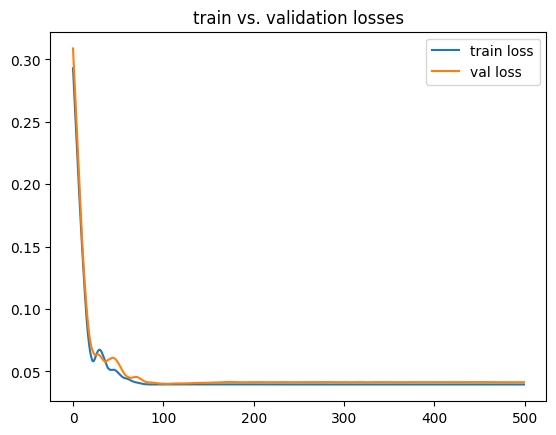

Saving model to models/chapter2_pytorch_workflow_exercise_model.pth
epoch 1000 | train loss: 0.03956089913845062 | eval loss: 0.04147494584321976


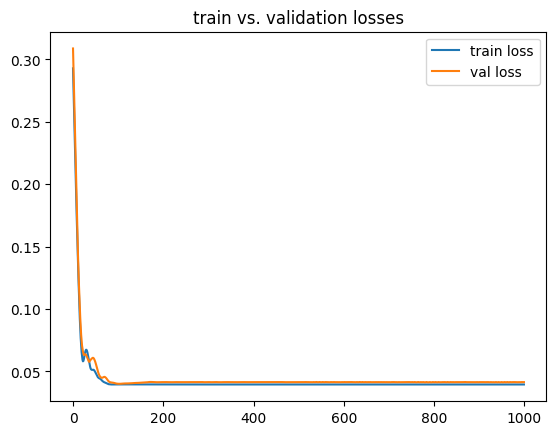

Saving model to models/chapter2_pytorch_workflow_exercise_model.pth
Saving model to models/chapter2_pytorch_workflow_exercise_model.pth


In [7]:
epochs=1000 # setting training epoch to 1000
train_losses, eval_losses=[],[]
for epoch in range(epochs+1):
  model.train()
  y_pred=model(X_train) # forward feeding X_train
  loss=loss_fn(y_pred, y_train) # getting training loss
  train_loss=loss.to('cpu').item() # turning train_loss to a single value
  optimizer.zero_grad()
  loss.backward() # back propagation
  optimizer.step() # optimizing

  model.eval() # evaluation and inference mode
  with torch.inference_mode():
    y_preds=model(X_test) # forward feed testing data
    val_loss=loss_fn(y_preds, y_test) # getting validation loss
    eval_loss=val_loss.to('cpu').item()
      
  if ((epoch % 500 == 0) & (epoch != 0)): # visualize validation for every 500 epochs
    print(f"epoch {epoch} | train loss: {train_loss} | eval loss: {eval_loss}")
    make_plots(X_test, y_test, y_preds)
    loss_plotting(train_losses, eval_losses)

    # save the model every 500 epochs
    print(f'Saving model to {model_save_path}')
    torch.save(
        obj=model.state_dict(),
        f=model_save_path
    )

  # append losses for plot making
  train_losses.append(train_loss)
  eval_losses.append(eval_loss)

# save the model every 500 epochs
print(f'Saving model to {model_save_path}')
torch.save(
    obj=model.state_dict(),
    f=model_save_path
)

In [8]:
# print out the state dict of current model
print(f'state dict of model: {model.state_dict()}')

## loading the saved model pytorch model
loaded_model=LinearModel()
loaded_model.load_state_dict(torch.load(f=model_save_path))

# compare for validating if the model's loaded correctly
loaded_model.eval()
with torch.inference_mode():
  y_pred=loaded_model(X_test)
make_plots(X_test, y_test, y_pred)
print(f'state dict of the loaded model: {loaded_model.state_dict()}')

state dict of model: OrderedDict([('linear_layer1.weight', tensor([[0.3694]])), ('linear_layer1.bias', tensor([0.8710]))])


state dict of the loaded model: OrderedDict([('linear_layer1.weight', tensor([[0.3694]])), ('linear_layer1.bias', tensor([0.8710]))])


It is seen in the final state dictionary, that the weight is very close to 0.3, and bias close to 0.9. The simple linear regression succeeded in modeling the fabricated noisy data.